# Libreta 3: Detección de Anomalías con LSTM Autoencoder + GMM

**Objetivo:** Implementar un modelo avanzado que utiliza un LSTM Autoencoder para aprender representaciones de secuencias de tiempo (los "ojos") y un Modelo de Mezcla de Gaussianas (GMM) para clusterizar estas representaciones y entender los estados operativos normales del horno (el "cerebro").

## Paso 1: Cargar y Preparar los Datos

- Cargamos el archivo `all_heats_consolidated.csv`.
- Seleccionamos un subconjunto de `HEATID`s para un desarrollo y entrenamiento más rápido. **Para el entrenamiento final, se debe usar el dataframe completo.**
- Escalamos las características numéricas a un rango de `[0, 1]`.
- Creamos las secuencias de datos (ventanas deslizantes) que servirán de entrada al Autoencoder.

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.mixture import GaussianMixture
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, RepeatVector, TimeDistributed
import matplotlib.pyplot as plt
import seaborn as sns

# Configuraciones
FILE_PATH = 'all_heats_consolidated.csv'
TIME_STEPS = 15  # Usaremos secuencias de 15 minutos
N_HEATIDS_TO_USE = 4166 # Número de HEATIDs para usar en este ejemplo. Cambiar a un número mayor o None para usar todos.

In [29]:
df = pd.read_csv(FILE_PATH)
df['HEATID'].nunique()

20827

In [2]:
print("Cargando datos consolidados...")
try:
    df = pd.read_csv(FILE_PATH)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    print(f"Datos cargados. Dimensiones: {df.shape}")
except FileNotFoundError:
    print(f"Error: El archivo {FILE_PATH} no fue encontrado. Asegúrate de ejecutar la libreta de preprocesamiento primero.")
    exit()

# Seleccionar un subconjunto de HEATIDs para agilizar el desarrollo
if N_HEATIDS_TO_USE is not None:
    unique_heatids = df['HEATID'].unique()
    selected_heatids = unique_heatids[:N_HEATIDS_TO_USE]
    df = df[df['HEATID'].isin(selected_heatids)]
    print(f"Usando un subconjunto de {len(selected_heatids)} HEATIDs.")

# Identificar columnas de características (excluyendo Timestamp y HEATID)
features = [col for col in df.columns if col not in ['Timestamp', 'HEATID']]
print(f"\nSe usarán {len(features)} características para el modelo.")

# Escalar los datos
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

print("Datos escalados.")

Cargando datos consolidados...
Datos cargados. Dimensiones: (7943618, 17)
Usando un subconjunto de 4166 HEATIDs.

Se usarán 15 características para el modelo.
Datos escalados.


In [3]:
# Función para crear secuencias agrupadas por HEATID
def create_grouped_sequences(data, group_by_col, features, time_steps=10):
    all_sequences = []
    grouped = data.groupby(group_by_col)
    for _, group in grouped:
        ts_data = group[features].values
        if len(ts_data) > time_steps:
            for i in range(len(ts_data) - time_steps + 1):
                all_sequences.append(ts_data[i:(i + time_steps)])
    return np.array(all_sequences)

print(f"Creando secuencias de {TIME_STEPS} pasos de tiempo...")
sequences = create_grouped_sequences(df, 'HEATID', features, TIME_STEPS)
print(f"Se crearon {sequences.shape[0]} secuencias.")
print(f"Dimensiones de las secuencias: {sequences.shape}") # (n_secuencias, n_pasos_tiempo, n_características)

Creando secuencias de 15 pasos de tiempo...
Se crearon 1089831 secuencias.
Dimensiones de las secuencias: (1089831, 15, 15)


## Paso 2: Construir el Modelo LSTM Autoencoder

El Autoencoder consta de dos partes:
1.  **Encoder:** Un LSTM que lee la secuencia de entrada y la comprime en un vector de estado de baja dimensión (la "memoria" o "representación latente").
2.  **Decoder:** Otro LSTM que toma el vector de estado y intenta reconstruir la secuencia de entrada original.

In [4]:
n_features = sequences.shape[2]
latent_dim = 32 # Dimensión del espacio latente (la "memoria"), esto lo hacemos para capturar la información más relevante de la secuencia de entrada

# --- Encoder ---
input_seq = Input(shape=(TIME_STEPS, n_features))
encoder = LSTM(128, activation='relu', return_sequences=True)(input_seq)
encoder = LSTM(64, activation='relu', return_sequences=False)(encoder)
latent_vector = Dense(latent_dim, activation='relu')(encoder) # El "vector de memoria"

# --- Decoder ---
# Repetimos el vector latente para cada paso de tiempo de la salida
decoder_input = RepeatVector(TIME_STEPS)(latent_vector)
decoder = LSTM(64, activation='relu', return_sequences=True)(decoder_input)
decoder = LSTM(128, activation='relu', return_sequences=True)(decoder)
output_seq = TimeDistributed(Dense(n_features))(decoder)

# --- Autoencoder Model ---
autoencoder = Model(inputs=input_seq, outputs=output_seq)
autoencoder.compile(optimizer='adam', loss='mse')

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 15, 15)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 15, 128)        │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 15, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 15, 64)         │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 15, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 15, 15)         │         1,935 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 250,799 (979.68 KB)

 Trainable params: 250,799 (979.68 KB)

 Non-trainable params: 0 (0.00 B)

## Paso 3: Entrenar el Autoencoder

Entrenamos el modelo para que aprenda a reconstruir secuencias "normales". El objetivo es minimizar el error de reconstrucción (MSE).

In [5]:
print("Entrenando el LSTM Autoencoder...")
history = autoencoder.fit(
    sequences, sequences, # La entrada y la salida son las mismas
    epochs=200, # Aumentar para un mejor rendimiento en el dataset completo
    batch_size=64,
    validation_split=0.1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, mode='min')
    ]
)
print("Entrenamiento completado.")

Entrenando el LSTM Autoencoder...
Epoch 1/200
 9438/15326 ━━━━━━━━━━━━━━━━━━━━ 6:53 70ms/step - loss: 0.0039

KeyboardInterrupt: 

## Paso 4: Extraer Representaciones Latentes (las "Memorias")

Ahora que el autoencoder está entrenado, creamos un modelo separado solo con la parte del **Encoder**. Usaremos este modelo para convertir todas nuestras secuencias normales en sus correspondientes "vectores de memoria".

In [22]:
encoder_model = Model(inputs=input_seq, outputs=latent_vector)

print("Extrayendo representaciones latentes de las secuencias...")
latent_representations = encoder_model.predict(sequences)
print(f"Dimensiones de las representaciones latentes: {latent_representations.shape}")

Extrayendo representaciones latentes de las secuencias...
249/249 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Dimensiones de las representaciones latentes: (7958, 32)


## Paso 5: Entrenar el Modelo de Mezcla de Gaussianas (GMM)

Usamos el GMM para encontrar clusters en el espacio de las representaciones latentes. Cada cluster representará un "estado operativo" normal del horno.

In [23]:
N_CLUSTERS = 5 # Hipótesis: hay 5 estados operativos principales. Se puede ajustar.

print(f"Entrenando el GMM con {N_CLUSTERS} clusters...")
gmm = GaussianMixture(n_components=N_CLUSTERS, random_state=42)
gmm.fit(latent_representations)
print("Entrenamiento del GMM completado.")

Entrenando el GMM con 5 clusters...
Entrenamiento del GMM completado.


## Paso 6: Definir Lógica de Detección de Anomalías

Ahora tenemos dos formas de detectar anomalías:
1.  **Error de Reconstrucción (Anomalía de Forma):** Si el autoencoder no puede reconstruir bien una secuencia, significa que la forma de la secuencia es anómala. Usaremos un umbral estadístico sobre el error (MSE).
2.  **Probabilidad del GMM (Anomalía de Estado):** Si una secuencia se reconstruye bien pero su "memoria" no encaja en ninguno de los clusters normales, es una anomalía de estado. Usaremos un umbral sobre el score de probabilidad del GMM.

In [24]:
# 1. Calcular errores de reconstrucción
print("Calculando errores de reconstrucción...")
reconstructed_seqs = autoencoder.predict(sequences)
reconstruction_errors = np.mean(np.square(sequences - reconstructed_seqs), axis=(1, 2))

# Definir umbral para el error de reconstrucción
reconstruction_threshold = np.mean(reconstruction_errors) + 3 * np.std(reconstruction_errors)
print(f"Umbral para error de reconstrucción (MSE): {reconstruction_threshold:.4f}")

# 2. Calcular scores de probabilidad del GMM
print("Calculando scores de probabilidad del GMM...")
gmm_scores = gmm.score_samples(latent_representations)

# Definir umbral para el score del GMM (usando un percentil)
gmm_threshold = np.percentile(gmm_scores, 5) # Consideramos anómalo el 5% de los estados menos probables
print(f"Umbral para score del GMM (log-probabilidad): {gmm_threshold:.4f}")

Calculando errores de reconstrucción...
249/249 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step
Umbral para error de reconstrucción (MSE): 0.0079
Calculando scores de probabilidad del GMM...
Umbral para score del GMM (log-probabilidad): 68.2029


## Paso 7: Aplicar y Visualizar Resultados en un HEATID de Ejemplo

Tomamos un `HEATID` del conjunto de prueba y aplicamos nuestra lógica de detección para ver los resultados.

In [25]:
# Tomar el primer HEATID como ejemplo
example_heatid = df['HEATID'].unique()[0]
df_example = df[df['HEATID'] == example_heatid]

# Crear secuencias para este HEATID
example_seqs = create_grouped_sequences(df_example, 'HEATID', features, TIME_STEPS)

# Obtener predicciones y scores para el ejemplo
example_reconstructed = autoencoder.predict(example_seqs)
example_errors = np.mean(np.square(example_seqs - example_reconstructed), axis=(1, 2))
example_latent = encoder_model.predict(example_seqs)
example_gmm_scores = gmm.score_samples(example_latent)

# Crear un dataframe con los resultados
df_plot = pd.DataFrame(index=df_example.index[TIME_STEPS-1:])
df_plot['Reconstruction_Error'] = example_errors
df_plot['GMM_Score'] = example_gmm_scores
df_plot['Reconstruction_Anomaly'] = example_errors > reconstruction_threshold
df_plot['State_Anomaly'] = example_gmm_scores < gmm_threshold
df_plot['TEMP'] = df_example['TEMP'][TIME_STEPS-1:]

print(f"Resultados para HEATID: {example_heatid}")
print(df_plot.head())

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Resultados para HEATID: 5F0002
    Reconstruction_Error  GMM_Score  Reconstruction_Anomaly  State_Anomaly  \
14              0.008485  77.743395                    True          False   
15              0.006587  76.002193                   False          False   
16              0.003476  77.455135                   False          False   
17              0.001928  76.920032                   False          False   
18              0.002056  76.239355                   False          False   

    TEMP  
14   0.0  
15   0.0  
16   0.0  
17   0.0  
18   0.0  


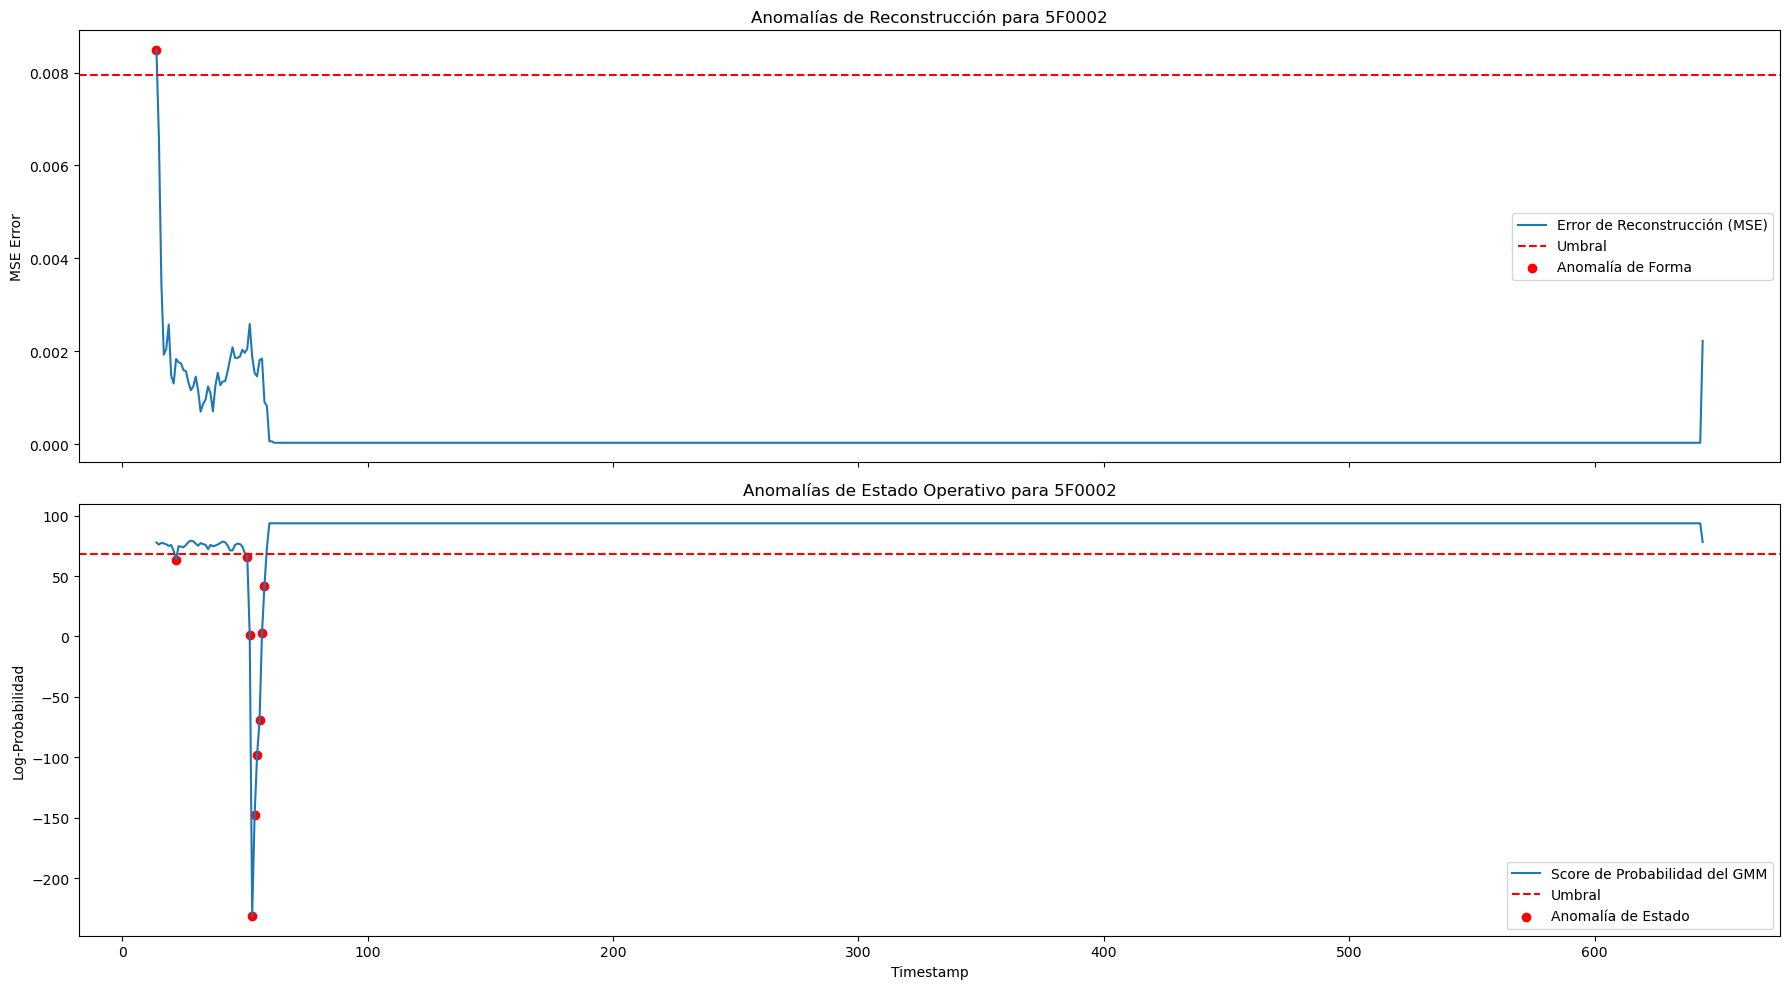

In [26]:
# Visualizar los resultados
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 10), sharex=True)

# Gráfico del Error de Reconstrucción
ax1.plot(df_plot.index, df_plot['Reconstruction_Error'], label='Error de Reconstrucción (MSE)')
ax1.axhline(reconstruction_threshold, color='r', linestyle='--', label='Umbral')
ax1.scatter(df_plot.index[df_plot['Reconstruction_Anomaly']], df_plot['Reconstruction_Error'][df_plot['Reconstruction_Anomaly']], color='red', label='Anomalía de Forma')
ax1.set_title(f'Anomalías de Reconstrucción para {example_heatid}')
ax1.set_ylabel('MSE Error')
ax1.legend()

# Gráfico del Score del GMM
ax2.plot(df_plot.index, df_plot['GMM_Score'], label='Score de Probabilidad del GMM')
ax2.axhline(gmm_threshold, color='r', linestyle='--', label='Umbral')
ax2.scatter(df_plot.index[df_plot['State_Anomaly']], df_plot['GMM_Score'][df_plot['State_Anomaly']], color='red', label='Anomalía de Estado')
ax2.set_title(f'Anomalías de Estado Operativo para {example_heatid}')
ax2.set_ylabel('Log-Probabilidad')
ax2.set_xlabel('Timestamp')
ax2.legend()

plt.tight_layout()
plt.show()